<a href="https://colab.research.google.com/github/setthawut8/ai/blob/main/nlp/%5Bclassification%5D_attention_bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## attention Layer

Bset Model:



#library and installation

In [1]:
#download data
!gdown --id :) 
!gdown --id :) 

!pip install keras-self-attention

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-avUDygRCGvAiPplmc6MundS_PpnohRv
To: /content/preprocessed_v1_socialfsi_single_train_sampling12150_20220701.xlsx
100% 3.87M/3.87M [00:00<00:00, 190MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=106OVRPIQQBppganRnCZigxQh6-Zyvqit
To: /content/preprocessed_v1_socialfsi_single_test_sampling389_20220701.xlsx
100% 141k/141k [00:00<00:00, 69.0MB/s]


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
train = pd.read_excel('/content/preprocessed_v1_socialfsi_single_train_sampling12150_20220701.xlsx')
test = pd.read_excel('/content/preprocessed_v1_socialfsi_single_test_sampling389_20220701.xlsx')

In [4]:
train.head(1)

,Unnamed: 0,TagFile_Path,TagFile,SV_CustomerName,Main keyword,Channel,SubChannel,lfdn,verbatim_id,sentence_id,Text_original,Text,Human_Category,Human_CategoryID,Human_Sentiment,Human_SentimentID,Text_ws_local
0,0,SocialFSI_ZE-KTB-Feb-Apr2022_Sampling2244_2022...,SocialFSI_ZE-KTB-Feb-Apr2022_Sampling1400_2022...,Krungthai_NEXT,"mobile banking+กสิกร,mobile banking+ธนาคารกสิก...",SocialMedia,forum,pantip.com_topic_41249919,Q2207_1549,Q2207_1549_1,สอบถามเรื่องการอายัดบัตรเดบิตของกสิกรค่ะ พอดีว...,สอบถามเรื่องการอายัดบัตรเดบิตของกสิกรค่ะ พอดีว...,"Product and Service, Usage and Condition",8,neutral,o,สอบถาม|เรื่อง|การ|อายัด|บัตรเดบิต|ของ|kbank|ค่...


In [5]:
test.head(1)

,Unnamed: 0,TagFile_Path,TagFile,SV_CustomerName,Main keyword,Channel,SubChannel,lfdn,verbatim_id,sentence_id,Text_original,Text,Human_Category,Human_CategoryID,Human_Sentiment,Human_SentimentID,Text_ws_local
0,0,SocialFSI_v4_0_mutiple_train_sampling8203_2021...,SocialFSI_SV-FSI-20201101-29-20201201-25_Sampl...,NaN,NaN,SocialMedia,Pantip,5fdb2543b08b582c303ceba3,Q202106_4598,Q202106_4598_1,ในอนาคตธนาคารเกียรตินาคินภัทรจะมีบัตรเครดิตไหม...,ในอนาคตธนาคารเกียรตินาคินภัทรจะมีบัตรเครดิตไหม...,"Product and Service, Variety",10,neutral,o,ในอนาคต|ธนาคาร|kk|ภัทร|จะ|มี|บัตรเครดิต|ไหม|คร...


#create a Vocabulary

In [15]:
from collections import Counter

vocab = Counter()
def data_to_vocab(df):
  for verbatim in df['Text_ws_local']:
    tokens = verbatim.split()
    tokens = [word for word in tokens if len(tokens) > 4] #at first = 1, CNN GMP is better with >4 for ~2%
    vocab.update(tokens)

data_to_vocab(train)

print(len(vocab))
vocab.most_common(20)

46943


[('|scb|', 1518),
 ('|friendtag|', 625),
 ('|2|', 512),
 ('|kbank|', 403),
 ('|บาท|', 360),
 ('|1|', 340),
 ('|3|', 329),
 ('|5|', 298),
 ('|tmb|', 251),
 ('|call_center|', 250),
 ('|atm|', 249),
 ('atm|', 245),
 ('|scb_easy|', 201),
 ('|telephonetag|', 199),
 ('|app|', 199),
 ('|กรุงไทย|', 198),
 ('|-|', 184),
 ('|sms|', 178),
 ('|ktc|', 176),
 ('|ของ|', 164)]

In [16]:
min_occurence = 2
tokens = [k for k, c in vocab.items() if c >= min_occurence]

In [17]:
def save_list(lines, filename):
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()
  
save_list(tokens, 'vocab.txt')

#preprocessing

In [18]:
#Load the vocab as above
def load_doc(filename):
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text

vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

print(vocab)

{'|ชื่อ|ญาติ|', '|จ้า', '|เป็นไร|วะ|', '|แล้วจะ|เอา|เงิน|ไป|ทำ|อะไร|ดี|นะ|', '|อี|ควาย|', '|precious|', '|ถือ|บัตร|', '|แบบ|ครับ|', '|ธนาคาร|แจ้ง|ว่า|', '|เกิด|จาก|อะไร|คะ|', '|ม|ค|', '|บ|ลา|', '|เบอร์|', '|จาก|ธนาคาร|', '|รอบ|นี้|', '|สินเชื่อ|', '|แย่|แย่|แย่', '|เป็นมา|', '|เรา|ได้|ทำการ|โอนเงิน|จาก|gsb|ผ่าน|', '|ระบบ|เป็น|อะไร|ครับ|', '|อยากจะ|สอบถาม|ว่า|', 'รอสาย|', '|บริการ|', 'บัตรเครดิต|', '|แบบนี้|ก็ได้|เหรอ|', '|ก็ได้|', '|ของ|วันนี้|', '|แต่|จริงๆ|', '|krungthai_care|', '15|', '|อ|ห|', '|ขอบพระคุณ|มาก|ครับ', '|investment|', 'atm|', 'รบกวน|สอบถาม|ค่ะ|', '|ล่ม', '|ซึ่ง|สถานการณ์|ตอนนี้|ก็|คือ|ไม่|อยาก|ออกไป|ไหน|เลย|', '|บ้าง|ครับ|', '|ดู|สรุป|ยอด|ซื้อ|', '|แบบนี้|เรา|ทำ|ยังไง|ได้|บ้าง|คะ|', 'โอนเงิน|จาก|กรุงไทย|', '|first|', '|เรียบร้อย|', 'ของ|เรา|', '|เงิน|ไม่|เข้า|เลย|ครับ|', '|ธนาคาร|นี้|', '|จะ|โอนเงิน|', '|วันนี้|ครบ|', '|ปี|แรก|', '|โอนเงิน|ไม่ได้|', '|atm|', '|เป็นต้นไป|', '|แอป|เป๋า|ตัง|', '|ฝ่าย|สินเชื่อ|', '|บอก|ว่า|', '|0.25|', '|ตัวอย่าง|', 'นี้|', '|9.00|', 'ผม|เ

In [19]:
#Turn Series into lists
train_docs = train['Text_ws_local'].tolist()
test_docs = test['Text_ws_local'].tolist()

In [20]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
#one hot-enconding for the text like > https://stackoverflow.com/questions/69026891/what-is-keras-tokenizer-fit-on-texts-doing
tokenizer.fit_on_texts(train_docs)
encoded_docs = tokenizer.texts_to_sequences(train_docs)

In [21]:
#Find the most max lengths of word in verbatims from both train and test
max_length_train = max([len(s.split()) for s in train_docs])
max_length_test  = max([len(s.split()) for s in test_docs])
max_length = max([max_length_train, max_length_test])
print("Max Length of Words: ", max_length)

#Padding in order to equalize some verbatims that do not contain the same length of the max length verbatim
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
#define the labels
ytrain = np.array(train['Human_CategoryID'].tolist())

Max Length of Words:  66


In [22]:
#Do the same for the test set
encoded_docs_test = tokenizer.texts_to_sequences(test_docs)

Xtest = pad_sequences(encoded_docs_test, maxlen=max_length)
ytest = np.array(test['Human_CategoryID'].tolist())

In [23]:
#Count unique classes
print(train['Human_CategoryID'].nunique(), test['Human_CategoryID'].nunique())

13 12


In [24]:
#Count unique classes
num_classes = max(train['Human_CategoryID'].nunique(), test['Human_CategoryID'].nunique())
print(num_classes)

13


In [25]:
from tensorflow.keras.utils import to_categorical

#Multi class problems need one-hot encoding on y
#why - 1 on ytrain and ytest? can follow the linke below
#https://stackoverflow.com/questions/56204731/the-method-np-utils-to-categorical-give-me-an-error/59002957#59002957
ytrain =  to_categorical(ytrain-1, num_classes=num_classes)
ytest = to_categorical(ytest-1, num_classes=num_classes)

In [26]:
vocab_size = len(tokenizer.word_index)+1

#model

##EL100 BILSTM128 M SSA F D13: 59
inspiration: 

https://datascience.stackexchange.com/questions/89884/the-use-of-keras-self-attention-module

In [153]:
import tensorflow as tf

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import Input
from keras.models import Sequential, Model
from keras_self_attention import SeqSelfAttention
from keras.layers.pooling import GlobalMaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Dropout,Bidirectional,Masking,LSTM, Embedding, Flatten, concatenate, Conv1D, MultiHeadAttention

In [154]:
model = Sequential()

model.add(Embedding(vocab_size, 100, input_length=max_length, trainable=True))
model.add(Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5, recurrent_dropout=0.7)))
model.add(Masking(mask_value=0.0)) #msdk sgyrt LSTM bettering the results
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 66, 100)           1260900   
                                                                 
 bidirectional_28 (Bidirecti  (None, 66, 256)          234496    
 onal)                                                           
                                                                 
 masking (Masking)           (None, 66, 256)           0         
                                                                 
 seq_self_attention_27 (SeqS  (None, 66, 256)          16449     
 elfAttention)                                                   
                                                                 
 flatten_16 (Flatten)        (None, 16896)             0         
                                                                 
 dense_31 (Dense)            (None, 13)              

In [155]:
from tensorflow.keras.callbacks import EarlyStopping

#put early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='min')

#Your choices of activation='softmax' in the last layer and compile choice of loss='categorical_crossentropy' 
#are good for a model to predict multiple mutually-exclusive classes.

model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['acc'],)

In [156]:
#when using class weights, it reduced acc significantly.

history = model.fit(Xtrain, ytrain, 
                    epochs=10, batch_size=64, 
                    validation_split=0.2,
                    callbacks=[early_stopping],)

Epoch 1/10
152/152 [==============================] - 70s 412ms/step - loss: 1.8045 - acc: 0.3900 - val_loss: 1.4003 - val_acc: 0.5391
Epoch 2/10
152/152 [==============================] - 61s 401ms/step - loss: 1.2098 - acc: 0.6142 - val_loss: 1.2888 - val_acc: 0.5872
Epoch 3/10
152/152 [==============================] - 58s 381ms/step - loss: 0.8921 - acc: 0.7129 - val_loss: 1.2460 - val_acc: 0.6177
Epoch 4/10
152/152 [==============================] - 58s 380ms/step - loss: 0.6469 - acc: 0.7908 - val_loss: 1.3927 - val_acc: 0.5922


In [157]:
loss, acc = model.evaluate(Xtest, ytest)
print('Test Accuracy: %f' % (acc*100))

13/13 [==============================] - 1s 58ms/step - loss: 1.3368 - acc: 0.5938
Test Accuracy: 59.383035


##EL100M0 BILSTM128 SSA AP1D F D13: 60

In [163]:
import tensorflow as tf

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import Input
from keras.models import Sequential, Model
from keras_self_attention import SeqSelfAttention
from keras.layers.pooling import GlobalMaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Dropout,Bidirectional,Masking,LSTM, Embedding, Flatten, concatenate, Conv1D

In [164]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length, trainable=True, mask_zero=True))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.5, recurrent_dropout=0.7)))
model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(AveragePooling1D()) 

### w/o CNN1D
#GMP1D = 24.9
#GAP1D = 31.1
#AP1D = 55

### w/o CNN1D, with mask_zero = True
#AP1D = 60

### with CNN1D(512, 5)
#AP1D = 53

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 66, 100)           1260900   
                                                                 
 bidirectional_30 (Bidirecti  (None, 66, 256)          234496    
 onal)                                                           
                                                                 
 seq_self_attention_29 (SeqS  (None, 66, 256)          16449     
 elfAttention)                                                   
                                                                 
 average_pooling1d_2 (Averag  (None, 33, 256)          0         
 ePooling1D)                                                     
                                                                 
 flatten_18 (Flatten)        (None, 8448)              0         
                                                     

In [165]:
from tensorflow.keras.callbacks import EarlyStopping

#put early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='min')

#Your choices of activation='softmax' in the last layer and compile choice of loss='categorical_crossentropy' 
#are good for a model to predict multiple mutually-exclusive classes.

model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['acc'],)

In [166]:
#when using class weights, it reduced acc significantly.

history = model.fit(Xtrain, ytrain, 
                    epochs=10, batch_size=64, 
                    validation_split=0.2,
                    callbacks=[early_stopping],)

Epoch 1/10
152/152 [==============================] - 80s 473ms/step - loss: 1.6510 - acc: 0.4555 - val_loss: 1.2627 - val_acc: 0.5778
Epoch 2/10
152/152 [==============================] - 70s 460ms/step - loss: 1.0516 - acc: 0.6532 - val_loss: 1.1662 - val_acc: 0.6103
Epoch 3/10
152/152 [==============================] - 70s 463ms/step - loss: 0.7455 - acc: 0.7529 - val_loss: 1.2220 - val_acc: 0.6111


In [167]:
loss, acc = model.evaluate(Xtest, ytest)
print('Test Accuracy: %f' % (acc*100))

13/13 [==============================] - 1s 69ms/step - loss: 1.2410 - acc: 0.6015
Test Accuracy: 60.154241


##EL100 BILSTM128 SSA F D13: 61
inspiration:

https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566

+

 https://medium.com/analytics-vidhya/https-medium-com-understanding-attention-mechanism-natural-language-processing-9744ab6aed6a


In [158]:
import tensorflow as tf

from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import Input
from keras.models import Sequential, Model
from keras_self_attention import SeqSelfAttention
from keras.layers.pooling import GlobalMaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Dropout,Bidirectional,Masking,LSTM, Embedding, Flatten, concatenate

In [159]:
model = Sequential()
model.add(Embedding(vocab_size, 1000, input_length=max_length, trainable=True))
model.add(Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.5, recurrent_dropout=0.7)))

## Embedding size = 100
#BiLSTM128 = 57
#BiLSTM256 = 60
#BiLSTM512 = 60

## Embedding size = 1000
#BiLSTM256 = 61

model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 66, 1000)          12609000  
                                                                 
 bidirectional_29 (Bidirecti  (None, 66, 512)          2574336   
 onal)                                                           
                                                                 
 seq_self_attention_28 (SeqS  (None, 66, 512)          32833     
 elfAttention)                                                   
                                                                 
 flatten_17 (Flatten)        (None, 33792)             0         
                                                                 
 dense_32 (Dense)            (None, 13)                439309    
                                                                 
Total params: 15,655,478
Trainable params: 15,655,478

In [160]:
from tensorflow.keras.callbacks import EarlyStopping

#put early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min')

#Your choices of activation='softmax' in the last layer and compile choice of loss='categorical_crossentropy' 
#are good for a model to predict multiple mutually-exclusive classes.

model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['acc'],)

In [161]:
#when using class weights, it reduced acc significantly.

history = model.fit(Xtrain, ytrain, 
                    epochs=10, batch_size=64, 
                    validation_split=0.2,
                    callbacks=[early_stopping],)

Epoch 1/10
152/152 [==============================] - 199s 1s/step - loss: 1.6045 - acc: 0.4670 - val_loss: 1.2183 - val_acc: 0.6053
Epoch 2/10
152/152 [==============================] - 186s 1s/step - loss: 0.9325 - acc: 0.6953 - val_loss: 1.1845 - val_acc: 0.6243
Epoch 3/10
152/152 [==============================] - 186s 1s/step - loss: 0.5289 - acc: 0.8278 - val_loss: 1.3356 - val_acc: 0.6284
Epoch 4/10
152/152 [==============================] - 187s 1s/step - loss: 0.2935 - acc: 0.9029 - val_loss: 1.6976 - val_acc: 0.6070


In [162]:
loss, acc = model.evaluate(Xtest, ytest)
print('Test Accuracy: %f' % (acc*100))

13/13 [==============================] - 3s 199ms/step - loss: 1.7451 - acc: 0.6118
Test Accuracy: 61.182517


#classification report and confusion matrix

In [112]:
from tensorflow.keras.utils import plot_model

In [106]:
#prediction
y_pred = model.predict(Xtest)

#Change one hot answer to be single digit as follows 
#https://stackoverflow.com/questions/54589669/confusion-matrix-error-classification-metrics-cant-handle-a-mix-of-multilabel

rounded_labels_ypred = np.argmax(y_pred, axis=1)
rounded_labels_ytest = np.argmax(ytest,axis=1)

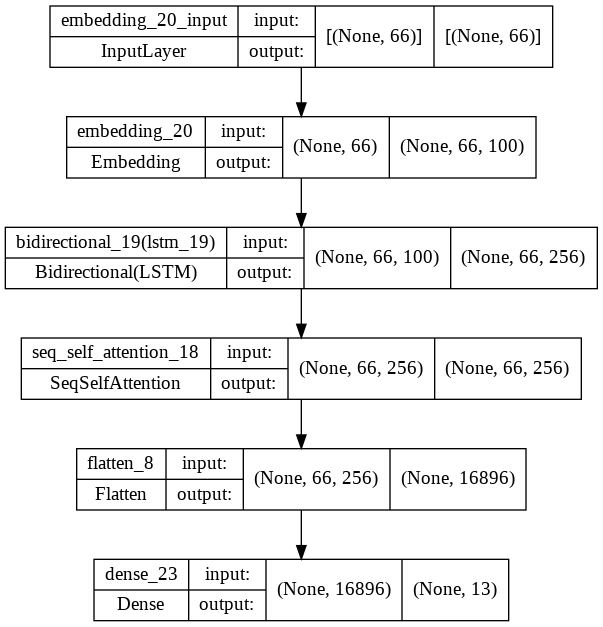

In [113]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# from google.colab import files
# files.download('model_plot.png')

In [108]:
#Find dict of label ids and names.
if train['Human_CategoryID'].nunique() < test['Human_CategoryID'].nunique():
  print('train_unique_classes')
  classes_with_id_dict = {id-1: labels for id, labels in zip(train['Human_CategoryID'], train['Human_Category'])}
  print(len(classes_with_id_dict))
else:
  print('test_unique_classes')
  classes_with_id_dict = {id-1: labels for id, labels in zip(test['Human_CategoryID'], test['Human_Category'])}
  print(len(classes_with_id_dict))

classes_with_id_dict

test_unique_classes
12


{0: 'Accessibility',
 2: 'Company Brand',
 3: 'Staff Quality',
 4: 'Timing',
 5: 'Product and Service, Benefit',
 6: 'Product and Service, System',
 7: 'Product and Service, Usage and Condition',
 8: 'Product and Service, Convenience',
 9: 'Product and Service, Variety',
 10: 'Product and Service, Decision',
 11: 'Security',
 12: 'No Category'}

In [109]:
#get an labels array in the conseuctive order based on id number.
train_unique_classes = train['Human_CategoryID'].nunique()
test_unique_classes = test['Human_CategoryID'].nunique()

#find the label total
if train['Human_CategoryID'].nunique() > test['Human_CategoryID'].nunique():
  print('test_unique_classes')
  classes_with_id = test_unique_classes
else:
  print('train_unique_classes')
  classes_with_id = train_unique_classes

#convert a dict to an array
classes_array = ["" for x in range(classes_with_id+1)]

for id, label in classes_with_id_dict.items():
  classes_array[id] = label

#delete empty string for classification report
classes_array = [label for label in classes_array if label != ""]
classes_array
print(len(classes_array))

test_unique_classes
12


In [110]:
from sklearn.metrics import classification_report

print(classification_report(rounded_labels_ytest, rounded_labels_ypred, target_names=classes_array, zero_division=0))

                                          precision    recall  f1-score   support

                           Accessibility       0.75      0.43      0.55         7
                           Company Brand       0.11      0.08      0.10        12
                           Staff Quality       0.42      0.29      0.34        17
                                  Timing       0.69      0.71      0.70        28
            Product and Service, Benefit       0.49      0.69      0.57        32
             Product and Service, System       0.76      0.79      0.77        84
Product and Service, Usage and Condition       0.63      0.57      0.60        92
        Product and Service, Convenience       1.00      0.18      0.31        11
            Product and Service, Variety       0.25      0.17      0.20        12
           Product and Service, Decision       1.00      0.20      0.33        10
                                Security       0.00      0.00      0.00         3
               

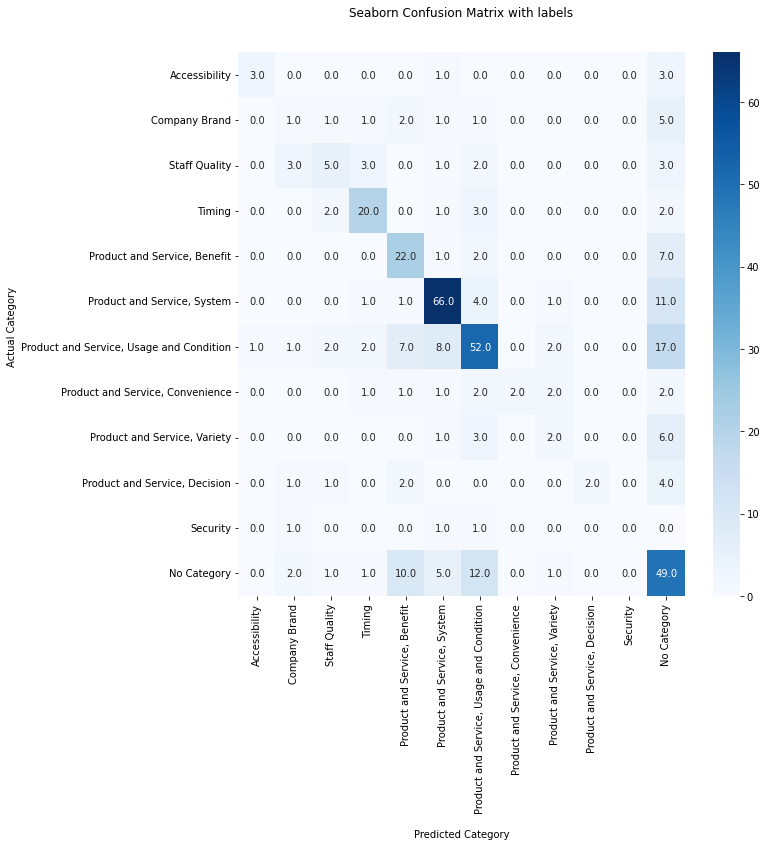

In [111]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(rounded_labels_ytest, rounded_labels_ypred)

fig, ax = plt.subplots(figsize=(10,10))    
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=ax, fmt=".1f")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(classes_array, rotation=90)
ax.yaxis.set_ticklabels(classes_array, rotation=0)

## Display the visualization of the Confusion Matrix.
plt.show()

figure = ax.get_figure()    
figure.savefig("cf_matrix.png", pad_inches= 12, dpi=400)